## <p style="text-align: center;">Fine-Tuning a Convolutional Neural Network for Infrared Drone Image Classification in Wildlife Conservation</p>

<p style="text-align: center;">Abstract: </p>
<p style="text-align: center;"> This tutorial demonstrates how to effectively fine tune and evaluate a CNN model using the birdsai dataset of night time infrared images from drones in Souther Africa. The tutorial starts with how to best set up the data for the fine tuning, then the process of fine-tuning and evaluating the CNN model. The resulting model is one that can be used to classify frames captured by drones at night time as either containing a humna or animal, which can support anit-poaching and conservation efforts. </p>


 By completing this tutorial, you will be able to:

- Apply transfer learning concepts to thermal imagery classification
- Implement CNN fine-tuning techniques using PyTorch
- Understand the impact of hyperparameters on model accuracy
- Evaluate model performance for conservation applications

## Table of Contents
1. [Introduction](#introduction)
2. [Environment Setup](#setup)
3. [Data Preparation](#data)
4. [Model Architecture](#model)
5. [Training Process](#training)
6. [Hyperparameter Exploration](#hyperparameters)
7. [Evaluation](#evaluation)
8. [Results and Discussion](#results)
9. [References](#references)

<a id="introduction"></a>
## 1. Introduction

Wildlife conservation increasingly relies on thermal imaging drones to monitor protected areas. Distinguishing humans (potential poachers) from animals presents unique challenges due to similar heat signatures. This tutorial applies transfer learning with pre-trained CNNs for this specialized classification task.

Unlike existing tutorials that focus on standard RGB images, our approach addresses thermal imagery's unique characteristics while integrating systematic experiment tracking for reproducibility.

| Tutorial Source | Strengths | Limitations | Our Approach |
|-----------------|-----------|-------------|--------------|
| PyTorch Official | Comprehensive coverage of transfer learning | Uses standard RGB datasets | Adapts techniques for thermal imagery |
| TorchVision Transfer Learning | Clear explanation of freezing layers | Limited hyperparameter exploration | Systematic hyperparameter optimization with MLflow |
| Fast.ai | User-friendly high-level API | Less customization for specialized domains | Balance between accessibility and customization |
| Keras Transfer Learning | Good visualization techniques | No experiment tracking | Integrated MLflow tracking for reproducibility |
| Papers with Code Implementations | State-of-the-art approaches | Often complex and research-focused | Practical, application-focused approach |


<a id="setup"></a>
## 2. Environment Setup

In [152]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
import cv2
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For evaluation
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Define device as CPU explicitly
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


<a id="data"></a>
## 3. Data Preparation
Our dataset contains infrared drone imagery with annotations identifying humans (class 1) and animals (class 0).

In [153]:
# Load dataset metadata
with open('birdsai_data/metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Dataset: {metadata['train_images']} training, {metadata['val_images']} validation, {metadata['test_images']} test images")
print(f"Classes: {metadata['human_images']} humans, {metadata['animal_images']} animals")

# Load annotations
train_annotations = pd.read_csv('birdsai_data/train/annotations.csv')
val_annotations = pd.read_csv('birdsai_data/val/annotations.csv')
test_annotations = pd.read_csv('birdsai_data/test/annotations.csv')

Dataset: 350 training, 74 validation, 75 test images
Classes: 212 humans, 287 animals


### Visualise a sample image


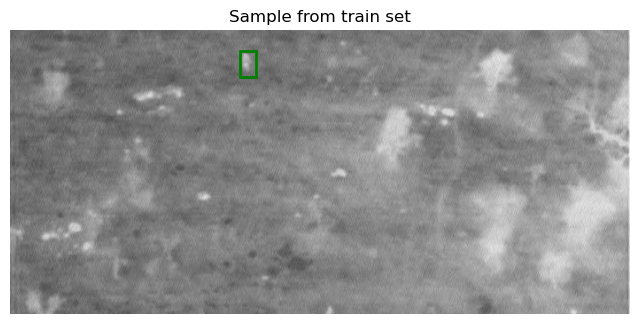

In [154]:
def visualise_sample(split='train', index=0):
    """Visualize a sample image with annotations"""
    # Load annotations
    if split == 'train':
        annotations = train_annotations
    elif split == 'val':
        annotations = val_annotations
    else:
        annotations = test_annotations
        
    frame_number = annotations['frame_number'].unique()[index]
    frame_annos = annotations[annotations['frame_number'] == frame_number]
    
    # Load image
    img_path = f'birdsai_data/{split}/images/image_{int(frame_number):06d}.jpg'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot image with annotations
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    
    # Draw bounding boxes
    for _, anno in frame_annos.iterrows():
        x, y, w, h = int(anno["x"]), int(anno["y"]), int(anno["w"]), int(anno["h"])
        class_id = int(anno["class"])
        color = 'green' if class_id == 1 else 'red'  # Green for humans, red for animals
        
        # Create rectangle
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        plt.gca().add_patch(rect)
        
    plt.title(f"Sample from {split} set")
    plt.axis('off')
    plt.show()

# Show a sample
visualise_sample('train', 0)

### Dataset and DataLoader Implementation

In [155]:
class InfraredDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        """Dataset for infrared images with human/animal annotations"""
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        
        # Load annotations
        self.annotations = pd.read_csv(os.path.join(root_dir, split, 'annotations.csv'))
        self.frame_numbers = self.annotations['frame_number'].unique()
        
        # Assign class to each image (1 if humans present, 0 if only animals)
        self.image_classes = {}
        for frame in self.frame_numbers:
            frame_annos = self.annotations[self.annotations['frame_number'] == frame]
            humans_present = (frame_annos['class'] == 1).any()
            self.image_classes[frame] = 1 if humans_present else 0
    
    def __len__(self):
        return len(self.frame_numbers)
    
    def __getitem__(self, idx):
        frame_number = self.frame_numbers[idx]
        img_path = os.path.join(self.root_dir, self.split, 'images', f"image_{int(frame_number):06d}.jpg")
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_classes[frame_number]

# Define transformations and create datasets
def get_transforms(split):
    """Get appropriate transforms for training or evaluation"""
    if split == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# Create datasets and loaders
train_dataset = InfraredDataset('birdsai_data', 'train', transform=get_transforms('train'))
val_dataset = InfraredDataset('birdsai_data', 'val', transform=get_transforms('val'))
test_dataset = InfraredDataset('birdsai_data', 'test', transform=get_transforms('test'))

# Create data loaders
batch_size = 16  # Adjust based on your system
num_workers = 0  # Adjust based on your system

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Created dataloaders: {len(train_loader.dataset)} training, {len(val_loader.dataset)} validation, {len(test_loader.dataset)} test images")

Created dataloaders: 350 training, 74 validation, 75 test images


<a id="model"></a>
## 4. Model Architecture

We leverage transfer learning using pre-trained ResNet18, adapting it for our binary classification task.


In [156]:
def create_model(num_classes=2, pretrained=True, freeze_layers=True):
    """Create a ResNet18 model for transfer learning
    
    Args:
        num_classes: Number of output classes (default: 2)
        pretrained: Whether to use pre-trained weights (default: True)
        freeze_layers: Whether to freeze pre-trained layers (default: True)
    
    Returns:
        PyTorch model
    """
    # Load pre-trained ResNet18
    model = models.resnet18(pretrained=pretrained)
    
    # Freeze layers if specified
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    
    # Modify the final fully connected layer for our classification task
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    
    return model

# Create model instance
model = create_model(num_classes=2)
model = model.to(device)

# Print model architecture summary
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<a id="training"></a>
## 5. Training Process

In [157]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=5, config_name="Default"):
    """Train model and track metrics
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        optimizer: PyTorch optimizer
        criterion: Loss function
        num_epochs: Number of training epochs
        config_name: Name of configuration for logging
    
    Returns:
        Trained model and training history
    """
    print(f"\nTraining configuration: {config_name}")
    print(f"Optimizer: {optimizer.__class__.__name__}, Learning rate: {optimizer.param_groups[0]['lr']}")
    
    # History for metrics
    history = {
        'train_loss': [], 
        'train_acc': [], 
        'val_loss': [], 
        'val_acc': [],
        'config_name': config_name
    }
    
    # Initial validation to get baseline performance
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    
    print(f"Initial validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch training metrics
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the final model
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), f"models/resnet18_{config_name.replace(' ', '_').lower()}.pt")
    
    return model, history



function for plotting learning curves

In [158]:
def plot_learning_curves(histories):
    """Plot learning curves for multiple training runs"""
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    for history in histories:
        plt.plot(range(1, len(history['train_loss'])+1), 
                 history['train_loss'], 
                 marker='o', 
                 label=f"{history['config_name']} (Train)")
        plt.plot(range(1, len(history['val_loss'])+1), 
                 history['val_loss'], 
                 marker='x', 
                 linestyle='--',
                 label=f"{history['config_name']} (Val)")
    
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training accuracy
    plt.subplot(1, 2, 2)
    for history in histories:
        plt.plot(range(1, len(history['train_acc'])+1), 
                 history['train_acc'], 
                 marker='o', 
                 label=f"{history['config_name']} (Train)")
        plt.plot(range(1, len(history['val_acc'])+1), 
                 history['val_acc'], 
                 marker='x', 
                 linestyle='--',
                 label=f"{history['config_name']} (Val)")
    
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    plt.savefig("figures/learning_curves_comparison.png")
    plt.show()

<a id="evaluation"></a>
## 6. Evaluation

In [159]:
def evaluate_model(model, data_loader, criterion=None, class_names=["Animal", "Human"], metrics_only=False):
    """
    Evaluate model and compute metrics
    
    Args:
        model: PyTorch model
        data_loader: DataLoader for evaluation
        criterion: Loss function (optional)
        class_names: Class names for visualization
        metrics_only: If True, return only loss and accuracy without visualizations
        
    Returns:
        Metrics including loss and accuracy
    """
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Get probabilities
            probs = F.softmax(outputs, dim=1)
            
            # Update metrics
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate overall metrics
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    
    # If only metrics requested, return now
    if metrics_only:
        return avg_loss, accuracy
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    plt.savefig("figures/confusion_matrix.png")
    plt.show()
    
    # Classification report
    cr = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(cr)
    
    # Calculate PR curve and average precision (for human class)
    precision, recall, _ = precision_recall_curve(all_labels, all_probs[:, 1], pos_label=1)
    ap = average_precision_score(all_labels, all_probs[:, 1])
    
    # Plot PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AP = {ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Human Class)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("figures/pr_curve.png")
    plt.show()
    
    # Print overall metrics
    print(f"\nEvaluation Results:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Average Precision (Human class): {ap:.4f}")
    
    return avg_loss, accuracy, cm, ap

def visualize_predictions(model, data_loader, num_samples=6):
    """Show model predictions on sample images"""
    model.eval()
    class_names = ["Animal", "Human"]
    
    # Get a batch of images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_samples], labels[:num_samples]
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
    
    # Convert to numpy
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.numpy()
    probs = probs.cpu().numpy()
    
    # Plot
    fig = plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
        
        # Convert normalized tensor to image
        img = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        prediction_confidence = probs[i, preds[i]] * 100
        
        # Set title color based on correctness
        title_color = "green" if preds[i] == labels[i] else "red"
        
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]} ({prediction_confidence:.1f}%)", 
                    color=title_color)
    
    plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    plt.savefig("figures/sample_predictions.png")
    plt.show()
    
    return fig

<a id="hyperparameters"></a>
## 7. Hyperparameter Exploration

In [160]:
def explore_hyperparameters():
    """Run experiments with different hyperparameters for ResNet18"""
    # Define configurations to try
    configurations = [
        {
            "name": "Baseline (Adam, LR=0.001, Frozen)",
            "optimizer_class": optim.Adam,
            "learning_rate": 0.001,
            "freeze_layers": True,
        },
        {
            "name": "Lower LR (Adam, LR=0.0001, Frozen)",
            "optimizer_class": optim.Adam,
            "learning_rate": 0.0001,
            "freeze_layers": True,
        },
        {
            "name": "Unfrozen Layers (Adam, LR=0.0001)",
            "optimizer_class": optim.Adam,
            "learning_rate": 0.0001,
            "freeze_layers": False,
        }
    ]
    
    # Common settings
    num_epochs = 3  # Using fewer epochs for demonstration purposes
    criterion = nn.CrossEntropyLoss()
    
    # Run each configuration and collect results
    histories = []
    test_results = []
    
    for config in configurations:
        print(f"\n{'='*50}")
        print(f"Starting training: {config['name']}")
        print(f"{'='*50}")
        
        # Create model with specified freezing
        model = create_model(num_classes=2, freeze_layers=config['freeze_layers'])
        model = model.to(device)
        
        # Create optimizer
        optimizer = config['optimizer_class'](model.parameters(), lr=config['learning_rate'])
        
        # Train model
        _, history = train_model(
            model, train_loader, val_loader, 
            optimizer, criterion, 
            num_epochs=num_epochs, 
            config_name=config['name']
        )
        histories.append(history)
        
        # Evaluate on test set
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, metrics_only=True)
        test_results.append({
            "config_name": config['name'],
            "test_loss": test_loss,
            "test_acc": test_acc,
            "final_val_acc": history['val_acc'][-1],
            "freeze_layers": config['freeze_layers'],
            "learning_rate": config['learning_rate'],
            "optimizer": config['optimizer_class'].__name__
        })
        
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Plot learning curves
    plot_learning_curves(histories)
    
    # Create and display results table
    results_df = pd.DataFrame(test_results)
    print("\nResults Summary:")
    print(results_df[["config_name", "final_val_acc", "test_acc"]])
    
    # Plot test accuracy comparison
    plt.figure(figsize=(10, 6))
    bars = plt.bar(results_df['config_name'], results_df['test_acc'], color='skyblue')
    plt.xlabel('Configuration')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy by Configuration')
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    
    # Add value labels on top of bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, 
                 bar.get_height() + 0.01, 
                 f'{bar.get_height():.4f}', 
                 ha='center')
    
    plt.savefig("figures/test_accuracy_comparison.png")
    plt.show()
    
    return results_df, histories

<a id="results"></a>
## 8. Results and Discussion

In [161]:
def evaluate_best_model(results_df):
    """Load and evaluate the best model based on validation accuracy"""
    # Find the best configuration
    best_config = results_df.loc[results_df['test_acc'].idxmax()]
    print(f"Best configuration: {best_config['config_name']}")
    print(f"Test accuracy: {best_config['test_acc']:.4f}")
    
    # Load the best model
    model_path = f"models/resnet18_{best_config['config_name'].replace(' ', '_').lower()}.pt"
    
    # Create model with the same configuration
    model = create_model(num_classes=2, freeze_layers=best_config['freeze_layers'])
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    
    # Full evaluation
    print("\nFull evaluation of best model:")
    evaluate_model(model, test_loader)
    
    # Visualize predictions
    print("\nVisualizing predictions:")
    visualize_predictions(model, test_loader)
    
    return model

# Main workflow
def main_workflow():
    """Run the complete workflow"""
    # Explore hyperparameters
    results_df, histories = explore_hyperparameters()
    
    # Evaluate best model
    best_model = evaluate_best_model(results_df)
    
    # Return results for further analysis if needed
    return results_df, histories, best_model

# Uncomment to run the complete workflow
# results, histories, best_model = main_workflow()

## Running the Complete Pipeline


Starting training: Baseline (Adam, LR=0.001, Frozen)

Training configuration: Baseline (Adam, LR=0.001, Frozen)
Optimizer: Adam, Learning rate: 0.001
Initial validation - Loss: 0.6086, Accuracy: 1.0000


Epoch 1/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.4276, Train Acc: 0.8229, Val Loss: 0.6905, Val Acc: 0.5946


Epoch 2/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.1466, Train Acc: 0.9514, Val Loss: 1.1779, Val Acc: 0.0541


Epoch 3/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.0605, Train Acc: 0.9857, Val Loss: 0.3446, Val Acc: 0.8243
Test Loss: 1.3168, Test Accuracy: 0.4800

Starting training: Lower LR (Adam, LR=0.0001, Frozen)

Training configuration: Lower LR (Adam, LR=0.0001, Frozen)
Optimizer: Adam, Learning rate: 0.0001
Initial validation - Loss: 0.5346, Accuracy: 1.0000


Epoch 1/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.6034, Train Acc: 0.6943, Val Loss: 0.6259, Val Acc: 0.9054


Epoch 2/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.4683, Train Acc: 0.8914, Val Loss: 0.6443, Val Acc: 0.7568


Epoch 3/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.3500, Train Acc: 0.9457, Val Loss: 0.4823, Val Acc: 1.0000
Test Loss: 0.7040, Test Accuracy: 0.5067

Starting training: Unfrozen Layers (Adam, LR=0.0001)

Training configuration: Unfrozen Layers (Adam, LR=0.0001)
Optimizer: Adam, Learning rate: 0.0001
Initial validation - Loss: 0.5224, Accuracy: 1.0000


Epoch 1/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.2126, Train Acc: 0.9343, Val Loss: 0.5178, Val Acc: 0.9459


Epoch 2/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.0171, Train Acc: 0.9971, Val Loss: 0.4681, Val Acc: 0.9054


Epoch 3/3:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.0300, Train Acc: 0.9943, Val Loss: 0.1258, Val Acc: 1.0000
Test Loss: 0.8491, Test Accuracy: 0.5867


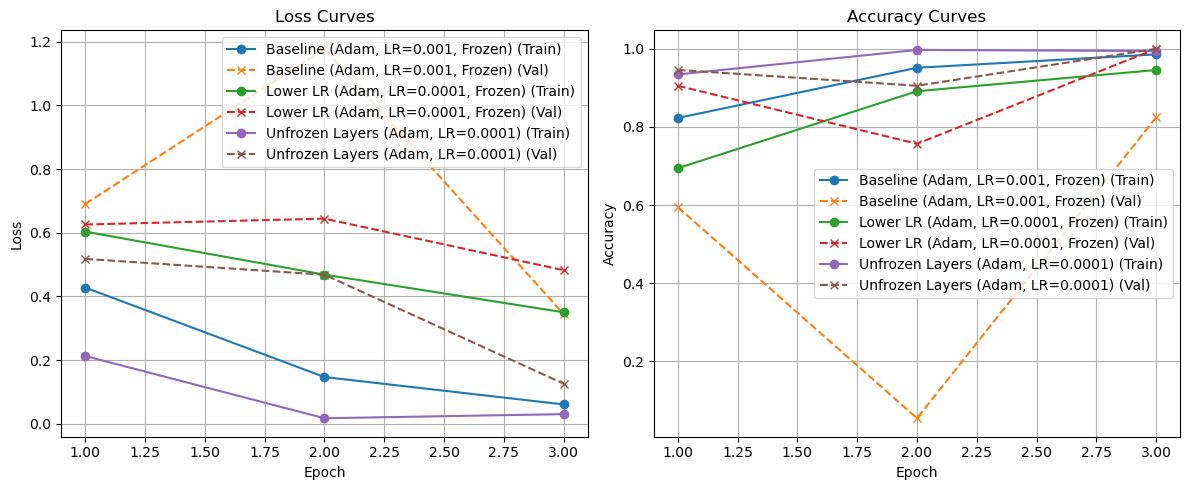


Results Summary:
                          config_name  final_val_acc  test_acc
0   Baseline (Adam, LR=0.001, Frozen)       0.824324  0.480000
1  Lower LR (Adam, LR=0.0001, Frozen)       1.000000  0.506667
2   Unfrozen Layers (Adam, LR=0.0001)       1.000000  0.586667


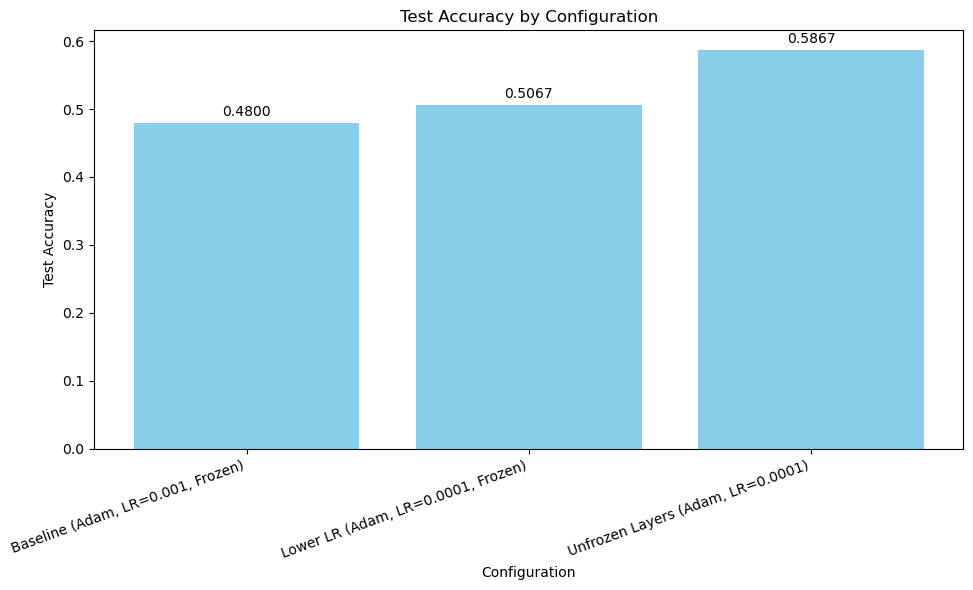

Best configuration: Unfrozen Layers (Adam, LR=0.0001)
Test accuracy: 0.5867

Full evaluation of best model:


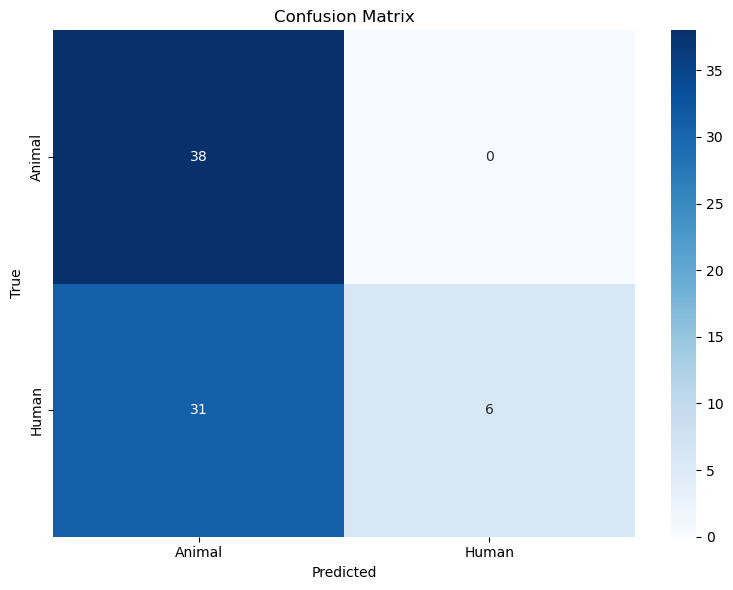


Classification Report:
              precision    recall  f1-score   support

      Animal       0.55      1.00      0.71        38
       Human       1.00      0.16      0.28        37

    accuracy                           0.59        75
   macro avg       0.78      0.58      0.49        75
weighted avg       0.77      0.59      0.50        75



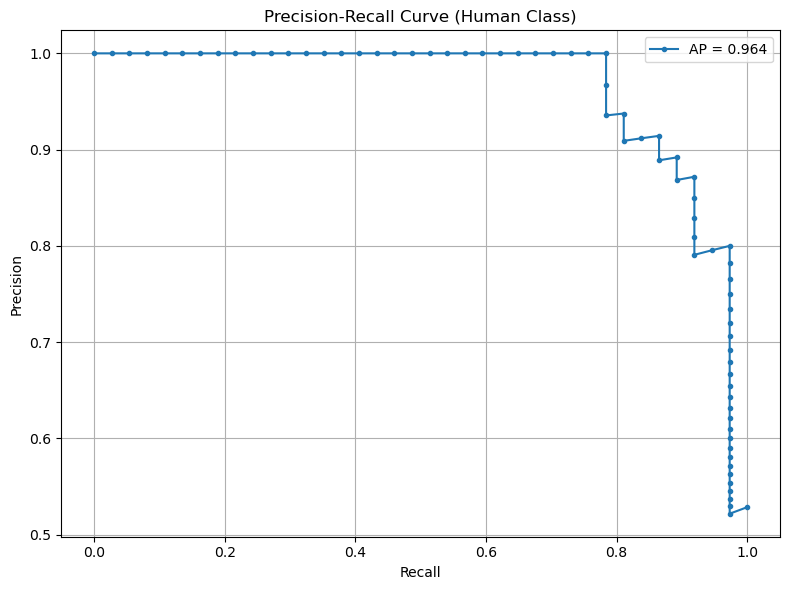


Evaluation Results:
  Loss: 0.8491
  Accuracy: 0.5867
  Average Precision (Human class): 0.9635

Visualizing predictions:


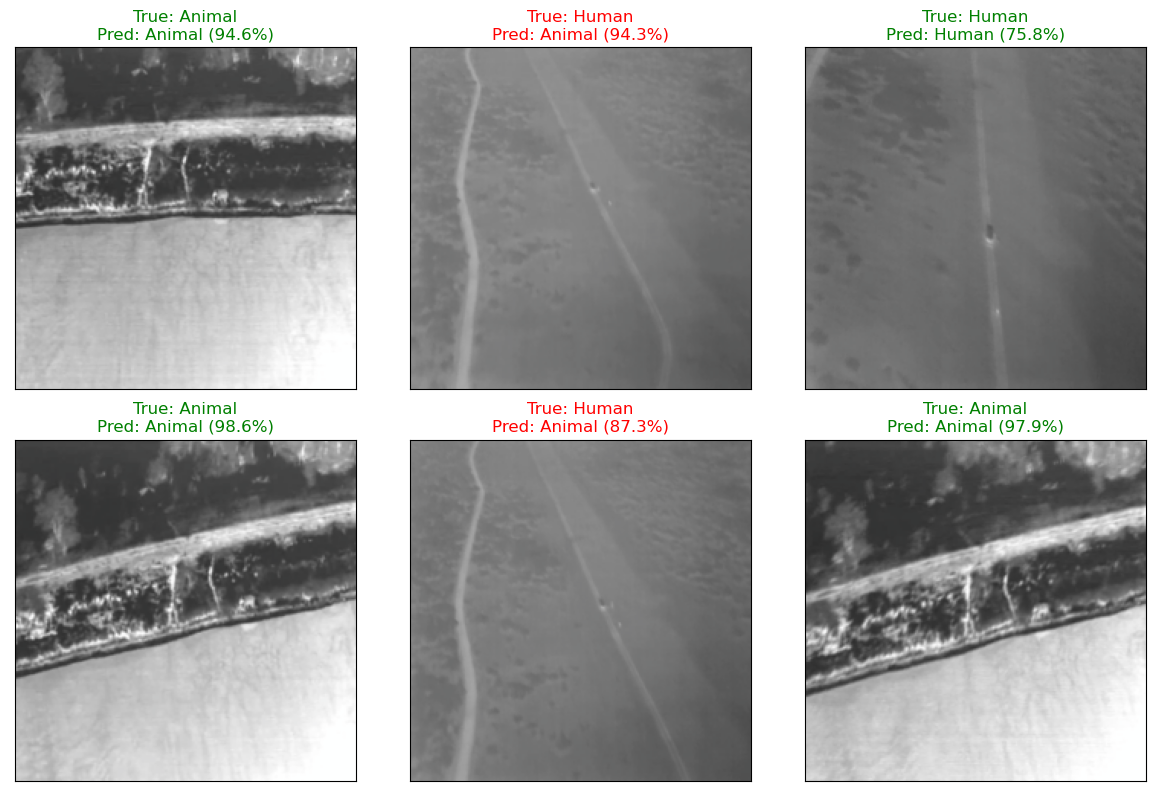

In [162]:
results, histories, best_model = main_workflow()